In [1]:
#%%
from lambeq import BobcatParser
from discocirc.closed import Func
from discocirc.sentence_to_circuit import make_term, make_diagram, sentence2circ
from discocirc.pulling_out import is_higher_order
from discocirc.term import Term
from discocirc.frame import Frame

#%%
parser = BobcatParser()
draw_term = lambda term: (Frame.get_decompose_functor())(make_diagram(term)).draw(figsize=(6, 10))


/Users/richie/Documents/work/discoket/lambeq/text2diagram/ccg_parser.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def just(term):
    name = term.name
    simple_type = term.simple_type
    return Term(name, simple_type, simple_type, [])


def pop(term):
    name = term.name
    simple_type = term.simple_type
    final_type = term.final_type
    last_arg = term.args[-1]
    
    new_final_type = last_arg.final_type >> final_type
    return Term(name, simple_type, new_final_type, term.args[:-1]), term.args[-1]


def thrush(f, g, h):
    typs = []
    simple_type = f.simple_type
    for arg in f.args:
        typs.append(simple_type.input)
        simple_type = simple_type.output
    h_type = h.final_type
    simple_type = (h_type >> simple_type.input) >> (h_type >> simple_type.output)
    final_type = simple_type
    for typ in typs[::-1]:
        simple_type = typ >> simple_type
    return Term(f.name, simple_type, final_type, f.args), g, h

In [3]:
# %%
sentence = "Alice quickly passionately gives Bob red flowers and blue smelly cheese"
sentence = "Alice is very sleepy and Bob is very sleepy"
sentence = "Alice quickly gives Claire red smelly fish"
diagram = parser.sentence2tree(sentence).to_biclosed_diagram()
term = make_term(diagram)

In [4]:
def check(f, g, h):
    # don't pull out higher order diagrams
    if isinstance(h.final_type, Func):
        return False
    # if nothing in g
    if f.simple_type.input == g.simple_type:
        return False
    # only pull out from a higher order box:
    if not is_higher_order(f.final_type):
        return False
    return True
        

def pull_out(term):
    if len(term.args) == 0:
        return term
    f = just(term)
    for arg in term.args:
        new_arg = pull_out(arg)
        if len(new_arg.args) > 0:
            g, h = pop(new_arg)
            assert new_arg == g(h)
            if check(f, g, h):
                f, g, h = thrush(f, g, h)
                assert pull_out(g) == g
                assert pull_out(h) == h
                f = pull_out(f(g))(h)
            else:
                f = f(new_arg)
        else:
            f = f(new_arg)

    return f

In [5]:
sentences = [
    "Alice quickly passionately gives Bob red flowers and blue smelly cheese",
    "Alice is very sleepy and Bob is very sleepy",
    "Alice quickly gives Claire red smelly fish"
]

trees = [parser.sentence2tree(sentence).to_biclosed_diagram() for sentence in sentences]
terms = [make_term(term) for term in trees]

In [6]:
%time
new_terms = [pull_out(term) for term in terms]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


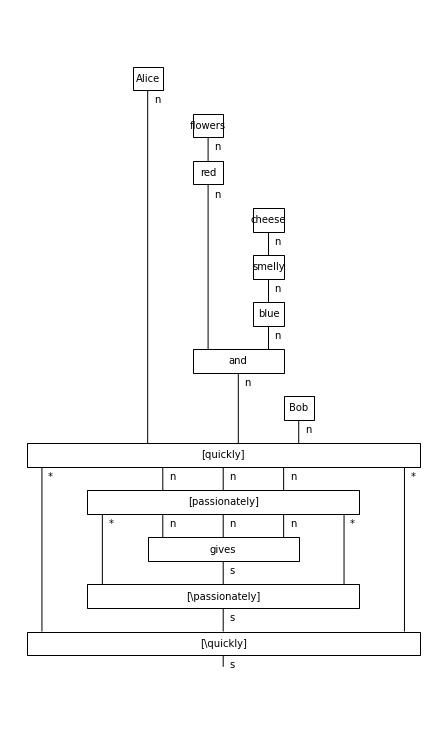

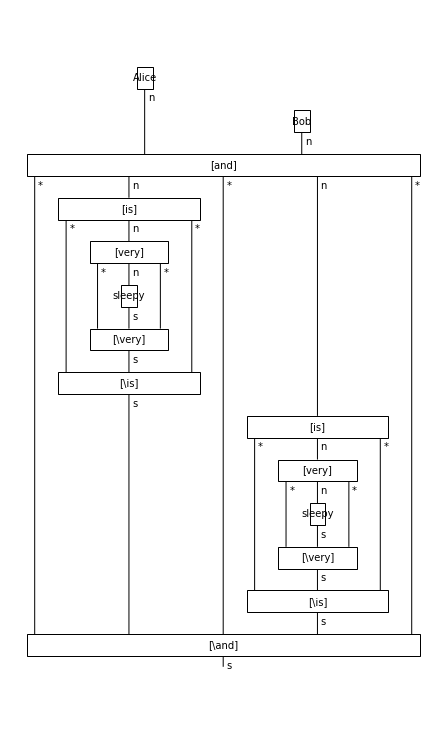

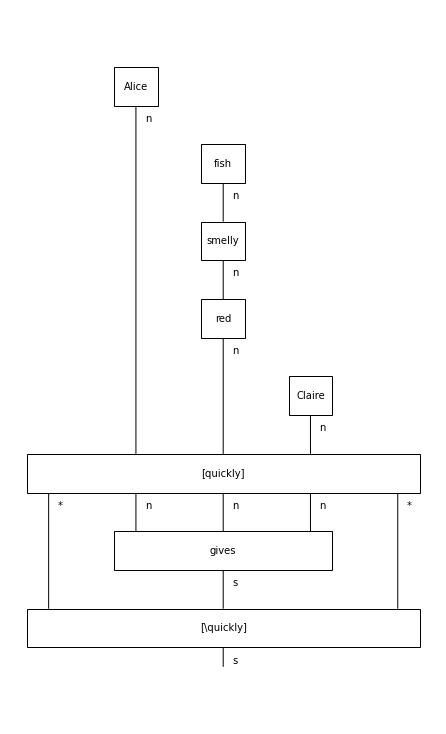

In [7]:
for term, new_term in zip(terms, new_terms):
#     draw_term(term)
    draw_term(new_term)
    